<h1>Projet : réalisation d’un codeur/décodeur JPEG simplifié</h1>

**JPEG** (Joint Photographic Experts Group) est l'encoding de l'image.

**JFIF** (JPEG File Interchange Format) est le format de fichier JPEG.

In [199]:
import numpy as np
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional
from functools import wraps

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())


Par la suite, on utilisera un [décorateur](https://pythonguide.readthedocs.io/en/latest/python/decorator.html) afin de simplifier la gestions de la dimension des canaux.
Dans toute la suite, on cosidèrera que la dimension des canaux est **la dernière dimension** des ndarray.
On parle alors du format **channel-last**.
D'autres formats sont possibles, mais on ne les utilisera pas dans ce projet.
Par exemple, le format **channel-first** est celui utilisé par `tensorflow` et `pytorch`.


Le décorateur `channels_handler(dims:int)` sera utilisé par la suite pour gérer la dimensions des canaux.
Il prend en paramètre le nombre de canaux de l’image `dims`.
Il est possible de l’utiliser sur toute fonction qui prend en premier paramètre positionnel un `ndarray` que l'on note `arr` pour les explications.

Le comportement du décorateur est le suivant en fonction du nombre de dimensions de `arr`.

Si le nombre de dimensions de `arr`
* n'est pas égal à `dims` ou `dims-1`, une erreur est levée.
* est égal à `dims`, le décorateur passe directement l’image à la fonction décorée. Le décorateur est transparent dans ce cas.
* est égal à `dims-1`, le décorateur ajoute une dimension de taille 1 à l’image avant de la passer à la fonction décorée et supprime cette dimension de taille 1 à la sortie de la fonction décorée.

En particulier, on peut être sur qu'une fois entrée dans la fonction décorée, le premier paramètre positionnel est un `ndarray` de dimension `dims`.

In [200]:
def unsqueeze_channels(arr:np.ndarray, dims:int) -> np.ndarray:
    assert dims > 0, 'Expected dims > 0'
    arr_dims = len(arr.shape)
    assert arr_dims in [dims-1, dims], f'Expected {dims} or {dims+1} dimensions, got {len(arr.shape)}'
    squeezed = arr_dims == dims-1
    if squeezed:
        arr = np.expand_dims(arr, axis=-1)
    return arr, squeezed

def squeeze_channels(arr:np.ndarray, squeezed:bool) -> np.ndarray:
    return arr[..., 0] if squeezed else arr

def channels_handler(dims:int=3):
    def decorator(function):
        @wraps(function)
        def wrapper(arr:np.array, *args, **kwargs):
            arr, squeezed = unsqueeze_channels(arr, dims)
            res = function(arr, *args, **kwargs)
            return squeeze_channels(res, squeezed)
        return wrapper
    return decorator


Prenons un exemple pour mieux comprendre le fonctionnement du décorateur.

Soit `f` une fonction qui travaille sur des images et renvoie la moyenne par ligne des canaux de l’image.

In [201]:
@channels_handler(dims=3)
def f(img):
    # une fois dans la fonction, on peut être sûr que img a dims=3 dimensions
    height, width, channels = img.shape
    # traitement de l'image
    # par exemple, on peut calculer la moyenne par ligne de chaque canal
    res = np.mean(img, axis=1)
    return res

height, width = 16, 9

# premier cas: img n'a que 2 dimensions (niveaux de gris)
# img.shape = (100, 100)
# le décorateur va ajouter une dimension de taille 1 à img avant et passer l'ndarray modifié à la fonction f
# img.shape = (100, 100, 1)
# la sortie sera un ndarray de shape (100, 100)
img = np.random.randint(0, 255, size=(height, width ), dtype=np.uint8)
res = f(img)
print(f"img.shape {img.shape} -> res.shape: {res.shape}")

# deuxième cas: img est toujours en niveaux de gris mais a 3 dimensions (la troisème dimension est de taille 1)
# img.shape = (100, 100, 1)
# dans ce cas, le décorateur passe directement img à la fonction f
img = np.random.randint(0, 255, size=(height, width , 1), dtype=np.uint8)
res = f(img)
print(f"img.shape {img.shape} -> res.shape: {res.shape}")

# troisième cas: img a 3 dimensions soit le nombre attendu
# le décorateur passe directement img à la fonction f
img = np.random.randint(0, 255, size=(height, width , 3), dtype=np.uint8)
res = f(img)
print(f"img.shape {img.shape} -> res.shape: {res.shape}")

img.shape (16, 9) -> res.shape: (16,)
img.shape (16, 9, 1) -> res.shape: (16, 1)
img.shape (16, 9, 3) -> res.shape: (16, 3)


# 1. Structure d’une image (non compressée)

L’image de départ est un tableau de M sur N pixels.
Pour une image en niveau de gris, chaque pixel est codé sur un octet (valeurs comprises entre 0 et 255).
Pour une image couleur, chaque pixel est codé sur trois octets, qui représentent les intensités des trois composantes
couleur: le rouge, le vert et le bleu.

## 1.1 Lecture d’une image

(256, 256) RGB None 0 255


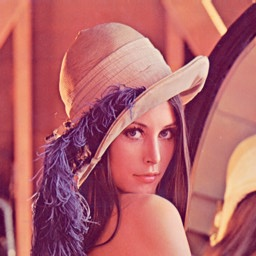

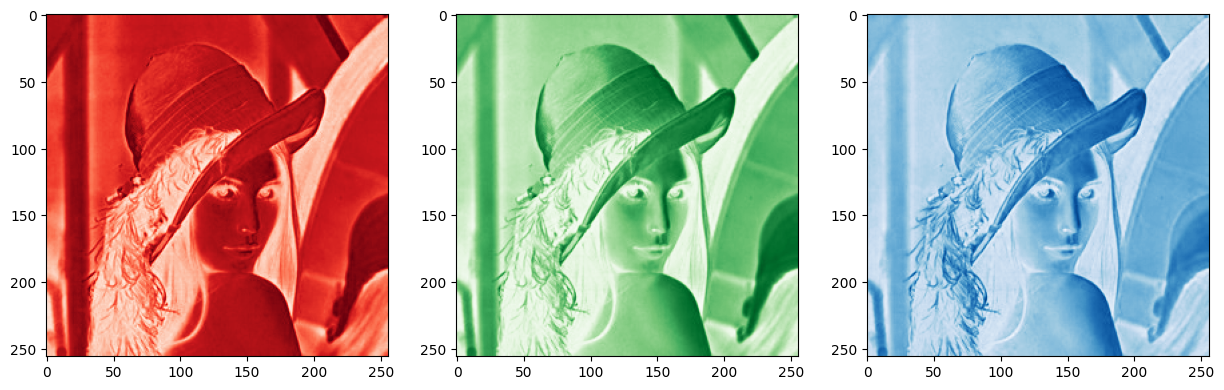

In [202]:
# load image as numpy array
url = "http://www.lenna.org/len_std.jpg"
img = load_from_url(url)

# show image
show(img)


# plot 3 channels : 
fig, (ax_R, ax_G, ax_B) = plt.subplots(1, 3, figsize=(15, 5))
ax_R.imshow(img[:, :, 0], cmap='Reds')
ax_G.imshow(img[:, :, 1], cmap='Greens')
ax_B.imshow(img[:, :, 2], cmap='Blues')
plt.show()

## 1.2 Padding de l’image

Dans toute la suite du TP, on travaillera avec des blocs carrés de 8x8 pixels.
Si l’image n’est pas un multiple de 8, on complète avec des pixels de valeur 0 (zeros padding).
Pour cela, on utilisera la fonction `np.pad` de numpy avec le paramètre `mode='constant'` et `constant_values=0`.

(300, 300) RGB None 0 255


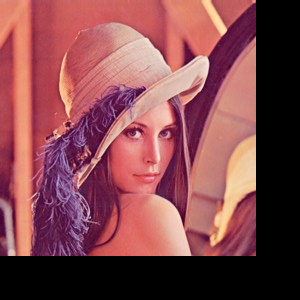

In [203]:
def zero_pad(img:np.ndarray, pad_h:int, pad_w:int=None): 
    '''
    Pad image with zeros on the right and bottom.
    '''
    if pad_w is None:
        pad_w = pad_h
    return np.pad(img, ((0,pad_w), (0,pad_h), (0,0)), mode='constant', constant_values=0)


def pad_multiple(img:np.ndarray, multiple:int):
    #TODO
    '''
    Pad image until number of rows and columns are a multiple of 'multiple'
    '''
    w = len(img[0])
    h = len(img)

    # pad_w = (multiple - (w % multiple))%multiple
    # pad_h = (multiple - (h % multiple))%multiple

    pad_w = multiple - (w % multiple)
    pad_h = multiple - (h % multiple)

    return zero_pad(img,pad_w,pad_h)


img_pad = pad_multiple(img, 100)
show(img_pad)

## 1.3 Découpage de l’image en blocs de NxNx3 pixels.

La fonction `patchify` prends en entrée une image de taille `(H, W, *)` ainsi que la taille des patchs `N` et renvoie un array de shape `(H//N, W//N, N, N, *)` contenant les blocs de pixels dont les deux premières dimensions correspondent aux coordonnées du bloc dans l’image.

Par exemple, si la taille des patch est de `10` et que l’image est de taille `(20, 30, 3)`,
la fonction doit retourner un array de shape `(2, 3, 10, 10, 3)`.
<img src="https://miro.medium.com/max/1400/1*-5_SB4EMeEJrkCc8gEdflA.jpeg" width=800>

(32, 32, 8, 8, 3)


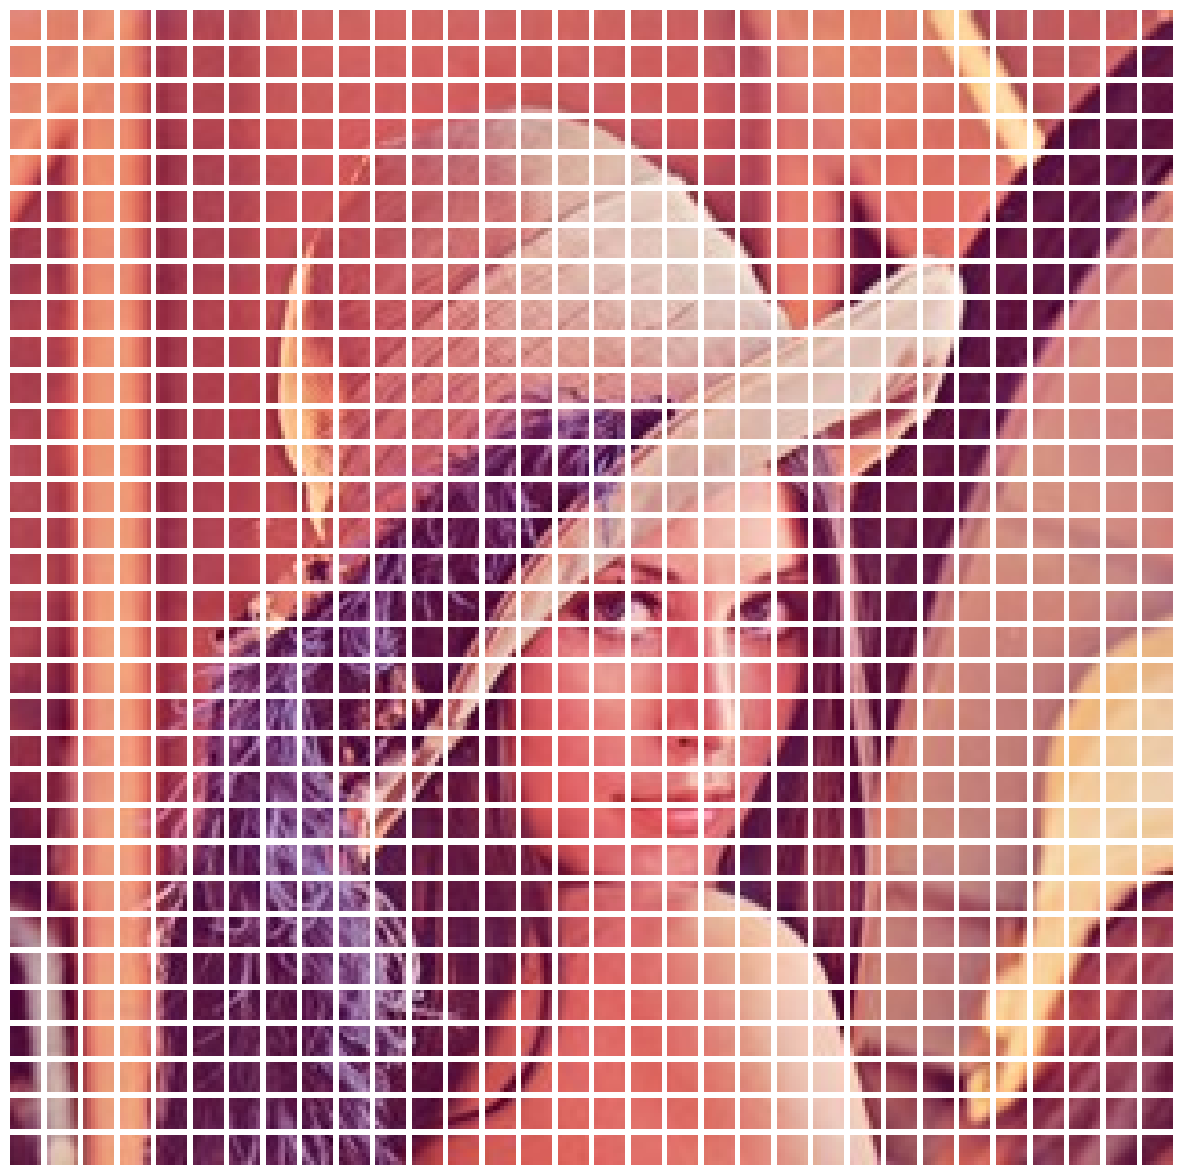

In [204]:
def get_patch(img:np.ndarray, r:int, c:int, patch_size:int=8) -> np.ndarray:
    #TODO
    ''' 
    Return the patch in the rth row, cth column. 
    For example for r=0, c=0 returns the first patch on the top left
    '''
    rstart = r*patch_size
    cstart = c*patch_size
    patch = img[rstart:rstart+patch_size, cstart:cstart+patch_size]
    return patch

@channels_handler(3)
def patchify(img:np.ndarray, patch_size:int) -> np.ndarray:
    #TODO
    '''
    Split image into patches of size patch_size.

    Returns:
        patches: (h // patch_size, w // patch_size, patch_size, patch_size, 3)
    '''
    h,w,c = img.shape
    row, col = h//patch_size, w//patch_size
    out = np.empty((row, col, patch_size,patch_size, 3), dtype = img.dtype)
    for r in range(row):
        for c in range(col):
            out[r,c] = get_patch(img, r, c, patch_size)
    return out
   

img_patches = patchify(img, 8)
print(img_patches.shape)
R, C = img_patches.shape[:2]

fig, axes = plt.subplots(R, C, figsize=(15, 15))
# disable axis
for ax in axes.flatten():
    ax.axis('off')
# plot patches
for r in range(R):
    for c in range(C):
        axes[r, c].imshow(img_patches[r, c])
plt.show()

(8, 8, 3)
(64, 64) RGB None 7 225


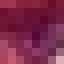

In [205]:
# accès à un seul patch
img_patch = img_patches[16, 16]
print(img_patch.shape)
# repeat each pixel 8 times
img_patch = np.repeat(np.repeat(img_patch, 8, axis=0), 8, axis=1)
show(img_patch)

Réaliser la fonction `unpatchify` qui prends en entrée un array de shape `(H//N, W//N, N, N, *)` et renvoie un array de shape `(H, W, *)` contenant les blocs de pixels concaténés.

Verifier que `unpatchify(patchify(img, patch_size))` renvoie bien  l'image original `img`.

img_patches (32, 32, 8, 8, 3) uint8 0 255
img_recon (256, 256, 3) uint8 0 255
(256, 256) RGB None 0 255


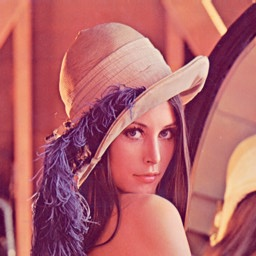

In [206]:
@channels_handler(5)
def unpatchify(patches:np.ndarray, height:int, width:int) -> np.ndarray:  
    '''
    Merge patches (H//N, W//N, N, N, channels) into image.
    '''
    rows, cols, patch_size_w, patch_size_h, channels = patches.shape
    assert patch_size_w == patch_size_h, f'{patch_size_w} != {patch_size_h}'
    patch_size = patch_size_w
    # check that patches fit into image
    assert height == rows * patch_size, f'{height} != {rows} * {patch_size}'
    assert width == cols * patch_size, f'{width} != {cols} * {patch_size}'

    img = np.empty((height, width, channels), dtype=patches.dtype)
    for r in range(rows):
        for c in range(cols):
            #TODO
            x0, y0 = r*patch_size_h, c*patch_size_w
            img[x0:x0+patch_size_h, y0:y0+patch_size_w] = patches[r,c]

    return img

# original
x = img_patches
x_height, x_width = img.shape[:2]
debug_ndarray(x, 'img_patches')

# reconstruction
x_r = unpatchify(x, x_height, x_width)
debug_ndarray(x_r, 'img_recon')
show(x_r)
assert np.all(img == x_r), 'img != img_recon'


Pour la suite, on aura besoin d'une fonction `serialize_patches` qui permet de "sérialiser" une image en une liste de patchs.

La fonction prend en entrée une image de taille `(H, W, *)` ainsi que la taille des patchs `N`.

Elle découpe l'image en patchs de taille `(N, N)` et regroupe tous les patchs dans la première dimension de l'array de sortie.

La fonction renvoie donc un array de shape `(H//N * W//N, N, N, *)`.

On aura aussi besoin d'une fonction `deserialize_patches` qui permet de "désérialiser" une liste de patchs en une image.

Verifier que `deserialize_patches(serialize_patches(img, patch_size), height, width, patch_size)` renvoie bien  l'image original `img`.

In [207]:
@channels_handler(3)
def serialize_patches(img:np.ndarray, patch_size:int=8, row_first:bool=True) -> np.ndarray:
    '''
    Input:
        image of shape (h, w, channels)

        row_first: if True,  [[a, b]   ->  [a, b, c, d]
                              [c, d]]
                   if False, [[a, b]   ->  [a, c, b, d]
                              [c, d]]
    Output:
        shape: (num_patches, patch_size, patch_size, channels)
        array where the first dimension is all the patches of shape


    img: (h, w, channels)
    where num_patches = (h // patch_size) * (w // patch_size) = R * C
    '''
    img_patches = patchify(img, patch_size)
    rows, cols = img_patches.shape[:2]

    I0, I1 = np.meshgrid(np.arange(cols), np.arange(rows))
    I0 = I0.flatten()
    I1 = I1.flatten()

    if row_first:
        return img_patches[I1, I0]
    else:
        return img_patches[I0, I1]

@channels_handler(4)
def deserialize_patches(patches:np.ndarray, height:int, width:int, patch_size:int=8, row_first:bool=True) -> np.ndarray:
    '''
    Input:
        patches: (num_patches, patch_size, patch_size, channels)
        img_size: (h, w)
        row_first: if True,  [[a, b]   ->  [a, b, c, d]
                              [c, d]]
                   if False, [[a, b]   ->  [a, c, b, d]
                              [c, d]]
    Output:
        image of shape (h, w, channels)
    '''
    rows, cols = height // patch_size, width // patch_size
    channels = patches.shape[-1]
    if row_first:
        patches = patches.reshape(rows, cols, patch_size, patch_size, channels)
    else:
        patches = patches.reshape(cols, rows, patch_size, patch_size, channels).swapaxes(0, 1)
    return unpatchify(patches, height, width)

x = img
x_height, x_width = img.shape[:2]
row_first=True
N = 8

x_ser = serialize_patches(x, patch_size=N, row_first=row_first)
debug_ndarray(x_ser, 'serialized')
print("num_patches:", x_ser.shape[0])

x_des = deserialize_patches(x_ser, x_height, x_width, patch_size=N, row_first=row_first)
debug_ndarray(x_des, 'deserialized')

assert np.all(x == x_des), 'Deserialized image is not the same as the original'




serialized (1024, 8, 8, 3) uint8 0 255
num_patches: 1024
deserialized (256, 256, 3) uint8 0 255


## 1.4 Conversion en luminance/chrominance

<img src="https://zestedesavoir.com/media/galleries/3582/8fe46086-775a-48ce-8b9f-6b3a5a16c4c4.png" width=800 />

Une autre représentation que le RGB est souvent utilisé : le Y Cb Cr.
* Y Luminance (intensité du pixel en niveau de gris)
* Cb Chrominance vers le Bleu
* Cr Chrominance vers le Rouge
L’image est alors constitué par trois tableaux d’octets,
associés respectivement aux trois grandeurs Y, Cr, Cb.


Les formules exactes ainsi que leurs approximations permettant de passer d’une représentation à l’autre sont données dans la spécification
**JPEG File Interchange Format (JFIF)** recommendation T.871 (05/11) de l'ITU-T.
Vous pouvez les trouver dans le document pdf sous le lien suivant:
[https://www.itu.int/rec/T-REC-T.871-201105-I/en](https://www.itu.int/rec/T-REC-T.871-201105-I/en)
Voir page 4 du document (page 10 du pdf)  "Conversion to and from RGB".

Remarque:
`Min( Max(a_min, a), a_max)` permet de s'assurer que toutes les valeurs de `a` sont comprise entre `a_min` et `a_max`.
Pour cela, elle remplace les valeurs inférieures à `a_min` par `a_min` et les valeurs supérieures à `a_max` par `a_max`.
En numpy on peut utiliser la fonction [`np.clip(x, a_min, a_max)`](https://numpy.org/doc/stable/reference/generated/numpy.clip.html).



In [208]:
def round_float(a: np.ndarray):
    return np.floor(a + 0.5)

def convert_to_u8(a):
    return np.clip(round_float(a), a_min=0, a_max=255).astype(np.uint8)

img_ycbcr (256, 256, 3) float64 20.463 239.242
img_rgb (256, 256, 3) uint8 0 255


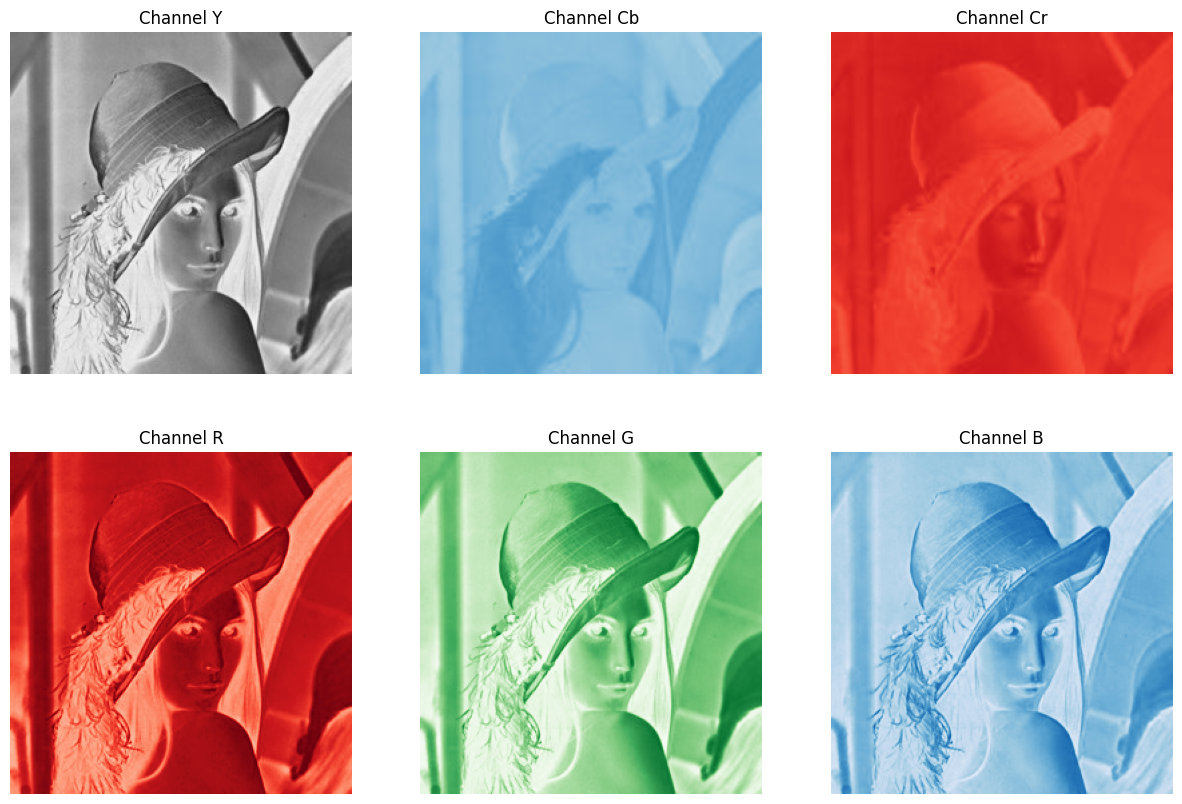

In [209]:
def convert_rgb_to_ycbcr(array: np.ndarray) -> np.ndarray:
    assert array.shape[2] == 3, "RGB image must have 3 channels"
    array = array.astype(np.float64)
    R, G, B = array[:, :, 0], array[:, :, 1], array[:, :, 2]
    
    Y  =  0.299 *R + 0.587 *G  + 0.114  *B
    Cb = ((-0.299 *R - 0.587 *G  + 0.886  *B) / 1.772) + 128
    Cr = ((0.701 *R - 0.587 *G  - 0.114  *B) / 1.402) + 128
    
    out = np.stack([Y, Cb, Cr], axis=2)
    return out


def convert_ycbcr_to_rgb(array: np.ndarray) -> np.ndarray:
    assert array.shape[2] == 3, "YCbCr image must have 3 channels"
    array = array.astype(np.float64)
    Y, Cb, Cr = array[:, :, 0], array[:, :, 1], array[:, :, 2]

    R = Y + 1.402 * (Cr - 128)
    G = Y - (0.114*1.772*(Cb - 128) + 0.299*1.402*(Cr - 128)) / 0.587
    B = Y + 1.772*(Cb - 128)
    
    out = np.stack([R, G, B], axis=2)
    return out


img_ycbcr = convert_rgb_to_ycbcr(img)
debug_ndarray(img_ycbcr, 'img_ycbcr')

img_rgb = convert_ycbcr_to_rgb(img_ycbcr)
img_rgb = convert_to_u8(img_rgb)
debug_ndarray(img_rgb, 'img_rgb')


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    # plot Y, Cb, Cr channels
    axes[0, i].imshow(
        img_ycbcr[:, :, i],
        cmap=['Greys', 'Blues', 'Reds'][i],
        vmin=0, vmax=255
    )
    axes[0, i].set_title(f"Channel " + str(['Y', 'Cb', 'Cr'][i]))
    axes[0, i].axis('off')
    # plot R, G, B channels
    axes[1, i].imshow(
        img_rgb[:, :, i],
        cmap=['Reds', 'Greens', 'Blues'][i],
        vmin=0, vmax=255
    )
    axes[1, i].set_title(f"Channel " + str(['R', 'G', 'B'][i]))
    axes[1, i].axis('off')
plt.show()


diff = np.abs(img_rgb - img)
assert diff.sum() == 0, "RGB and YCbCr conversion is not correct"

## 1.5 Sous-échantillonage chromatique (chroma subsampling)

La représentation Y Cb Cr est plus efficace en terme de compression (et donc plus souvent utilisée).
En effet, on peut sous-échantillonner les deux signaux de chrominance car l’œil humain est moins sensible à la chrominance.

La notation $J:a:b$ est la plus fréquemment utilisée pour décrire le sous-échantillonage.
Elle consiste en trois nombres séparés par des deux-points.
* $J$: nombre de pixels d'intensité conservés pour chaque groupe de quatre pixels affichés sur une ligne.
* $a$: nombre de pixels de couleur conservés pour chaque groupe de quatre pixels affichés sur les lignes paires.
* $b$ nombre de pixels de couleur conservés pour chaque groupe de quatre pixels affichés sur les lignes impaires.

<img src="https://docs.google.com/drawings/d/e/2PACX-1vT36L1iZQntPuGSM2NVakkM0G6IAk2g88fG_-flf9q-7yqw9tyIA-nZEufy6OlmNIZXkb5xrJLqHlSz/pub?w=618&h=336&&&&&&&&&&&&&&&&&&&" width=800>


Les formats suivants sont fréquemment utilisés:

* (4:4:4) dans le format le plus simple et le moins compressé, les trois tableaux Y , Cr, Cb ont les mêmes dimensions, M
et N, égales aux dimensions de l’image originale.

* (4:2:2)

* (4:2:0) un format plus efficace en terme de compression (et donc plus souvent utilisé) consiste à sous-échantillonner les
deux signaux de chrominance d’un facteur 2 (l’œil humain est moins sensible à la chrominance). Plus précisément, avec
le facteur 2, le tableau Y reste de taille [M, N] mais les tableaux Cr et Cb sont de dimension [M/2, N/2] (la valeur de
chrominance est associée à quatre pixels voisins).



# 2. Encodage avec perte d’une data unit

Le codeur JPEG travaille sur des data unit qui sont des blocs de taille N × N d’une image. Chaque composante
est découpée en carrés de N × N pixels. Si les dimensions de la composante ne sont pas des multiples de N, l’image est
complétée par duplication de la dernière ligne (ou colonne) jusqu’à obtenir le multiple de N immédiatement supérieur.
Chaque carré N × N est ensuite traité indépendamment, en décrivant l’image de gauche à droite et de haut en bas.

## 2.1 Centrage

Les échantillons des carrés N × N sont des nombres compris entre 0 et 255. La première opération à réaliser est un
centrage afin d’obtenir des valeurs comprises entre -128 et 127 (en retirant 128 à chaque valeur). Les valeurs centrées
seront notées f(i, j) avec i, j ∈ [0, N-1].

*Question: Pourquoi cette étape est nécessaire ?*

Le centrage nous permet de normaliser notre repère en un nouveau plus adapté aux fonctions de compressions utilisées par la suite.

In [210]:
def centering(img, value:int=128, dtype=np.float64):
    #TODO, remember that img.dtype = uint8 
    return img.astype(dtype) - value 

def decentering(img, value:int=128, dtype=np.float64):
    #TODO
    return img.astype(dtype) + value

x = img
x_enc = centering(x)
x_dec = decentering(x_enc)
assert (x == x_dec).all(), "centering / decentering failed"

## 2.2 Transformée en cosinus (DCT)

Dans toute la suite, $N=N$ est la taille des blocs N × N.

Après avoir réalisé le centrage, il faut calculer la transformée en cosinus discrète (DCT) de chaque carré N × N.
La DCT est une transformée fréquentielle qui est équivalente à la partie réelle de la transformée de Fourier discrète (DFT).

Cette transformation donne une nouvelle matrice N × N de coefficients, appelée $F(u, v)$, $u, v \in [0, N-1]$.
Elle décompose un bloc, considéré comme une fonction numérique à
deux variables, en une somme de fonctions cosinus oscillant à des fréquences différentes.
Chaque bloc est ainsi décrit en une carte de fréquences et en amplitudes plutôt qu’en pixels et coefficients de couleur.
Pour le décodage, on peux retrouver les $f(i, j)$ à partir de la transformée 2D inverse des $F(u, v)$.


### 2.2.1 Transformée en cosinus 1D

$$ F(u)= \text{scaling}(N) \times C(u) \sum_{i=0}^{N-1} f(i)\cos\left({\frac{(2i+1)u\pi}{2 N}}\right) $$

$$ f(i)= \text{scaling}(N) \sum_{u=0}^{N-1} C(u) F(u) \cos\left({\frac{(2i+1)u\pi}{2 N}}\right) $$

* $F(u)$ : valeur de coefficient dans le domaine de transformation
* $f(i)$ : valeur de coefficient dans le domaine de pixel
* $i$ : coordonnée spatiale dans le domaine de pixel
* $u$ : coordonnée dans le domaine de transformation

avec
$$C(u)=\begin{cases}
    1 / \sqrt{2}&, & \text{si $u=0$}.\\
               1&, & \text{sinon}.
  \end{cases}$$
et
$$\text{scaling}(N)=\sqrt{\frac{2}{N}}$$
En utilisant ces définitions de $C$ et $\text{scaling}$, on peut rendre la DCT directe et inverse transposées l'une de l'autre.
Cela rend la matrice de la DCT inverse orthogonale, mais rompt la correspondance directe avec une DFT réelle et paire de sortie décalée de moitié.
C'est notamment la normalisation faites dans matlab et utilisé dans JPEG2000.


**Conseil**: Verifier que la matrice obtenue est bien orthonormée.

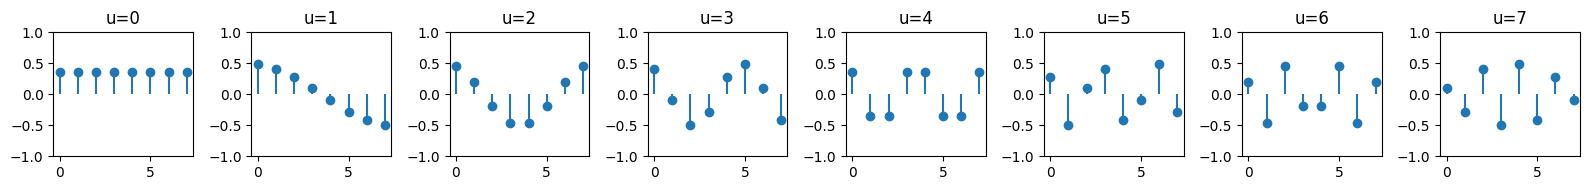

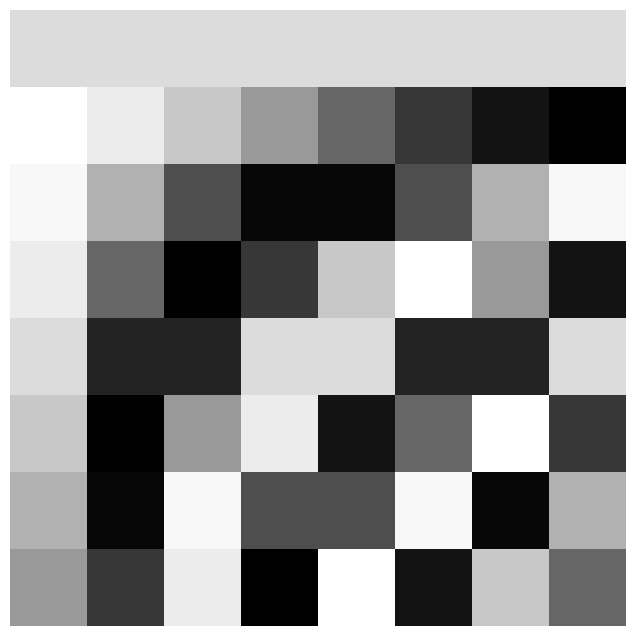

In [211]:
def construct_dct1d_basis(n:int):
     ''' Construct 1D DCT basis of size n x n'''
     i = np.arange(n)
     k = i[..., np.newaxis]

     scaling = np.sqrt(2 / n)

     # Compute 1D DCT basis
     dct1d_basis = np.cos((2 * i + 1) * (k * np.pi) / (2 * n)) * scaling 

     # C(x) = 1/sqrt(2) for x=0 and 1 otherwise
     dct1d_basis[0] /= np.sqrt(2)
     #dct1d_basis[1:] *=  1

     return dct1d_basis

N = 8
dct1d_basis = construct_dct1d_basis(N)
assert dct1d_basis.shape == (N, N), "DCT matrix should be 8x8"

# plot functions of DCT basis
fig, axs = plt.subplots(1, N, figsize=(N*2, 2))
for u in range(N):
     for v in range(N):
          axs[u].stem(v, dct1d_basis[u, v])
     axs[u].set_ylim(-1, 1)
     axs[u].set_title(f"u={u}")
fig.tight_layout()

# plot DCT matrix as an image
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(dct1d_basis, cmap='gray')
ax.axis('off')


# check orthonormality
M = dct1d_basis @ dct1d_basis.T
M_id = np.eye(N)
assert np.allclose(M, M_id), "DCT matrix is not orthonormal"


### 2.2.2 Transformée en cosinus 2D


L'équation de cette transformée est la suivante:

$$ F(u,v)={\text{scaling}(N)}^2 \times C(u) C(v) \sum_{i=0}^{N-1}\sum_{j=0}^{N-1}f(i,j)\cos\left({\frac{(2i+1)u\pi}{2N}}\right)\cos\left({\frac{(2j+1)v\pi}{2N}}\right) $$

L’application de la DCT est une opération théoriquement sans perte d’informations:
les coefficients initiaux peuvent être retrouvés en appliquant la DCT inverse au résultat de la DCT.
L'équation de la transformée inverse est:

$$ f(i,j)={\text{scaling}(N)}^2 \times \sum_{u=0}^{N-1}\sum_{v=0}^{N-1}C(u) C(v) F(u,v)\cos\left({\frac{(2i+1)u\pi}{2N}}\right)\cos\left({\frac{(2j+1)v\pi}{2N}}\right) $$

* $F(u,v)$ : valeurs de coefficient dans le domaine de transformation
* $f(i,j)$ : valeurs de coefficient dans le domaine de pixel
* $i,j$ : coordonnées spatiales dans le domaine des pixel
* $u,v$ : coordonnées dans le domaine de transformation


### 2.2.3 Implémentation efficace de la DCT 2D

Bien que l'on puisse calculer la DCT en utilisant la formule ci-dessus,
il est plus efficace de calculer la DCT en utilisant les deux propriétés suivante:

* Séparabilité: la DCT 2D peut être réalisé en appliquant des transformations DCT 1D, successivement sur les lignes et les colonnes.
  Cela revient à calculer la DCT 1D ligne puis de répéter cette opération sur la transposée du résultat.
  En utilisant la séparabilité, on peut réecrire la définition de la DCT 2D comme:
  $$ F(u, v)= \text{scaling}(N) C_u \sum_{i=0}^{N-1}
  \Biggl\{ \text{scaling}(N) C_v \sum_{j=0}^{N-1} f(i, j)\cos\left({\frac{(2j+1)v\pi}{2 N}}\right)   \Biggl\}
  \cos\left({\frac{(2i+1)u\pi}{2 N}}\right) $$

* Dans cette base, la matrice en (u, v) est la transposée de la matrice en (v, u).

Utiliser la fonction [`np.outer`](https://numpy.org/doc/stable/reference/generated/numpy.outer.html)

**Conseil**: afficher les DCT de différents blocs et interpréter les résultats.

dct2d_basis (8, 8, 8, 8) float64 -0.24048494156391095 0.24048494156391095


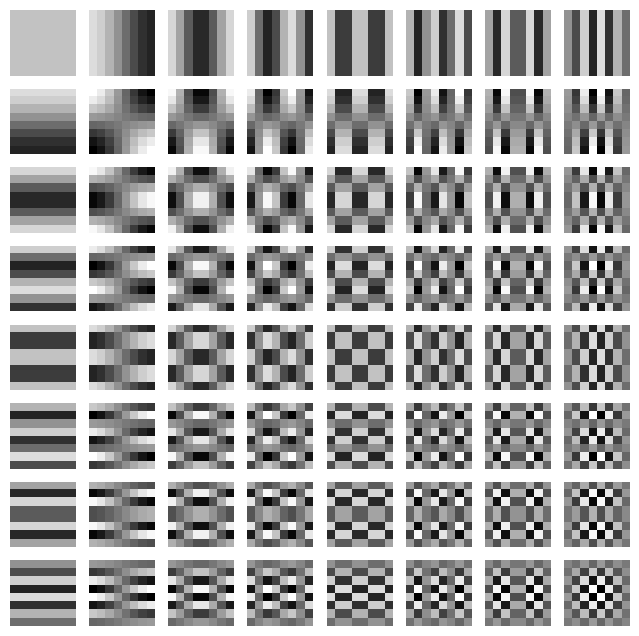

In [212]:
def construct_dct2d_basis(n: int) -> np.ndarray:
    """ Construct 2D DCT basis of size n x n x n x n"""
    assert n > 0, "n must be positive"
    dct1d_basis = construct_dct1d_basis(n)

    dct2d_basis = np.empty((n, n, n, n), dtype=np.float64)
    # do n*(n+1)/2 steps instead of n*n steps
    # because of symmetry
    for u in range(n):
        for v in range(u, n):
            # separability of DCT
            dct2d_u_v_mat = np.outer(dct1d_basis[u], dct1d_basis[v])
            dct2d_basis[u, v] = dct2d_u_v_mat

            # get (v, u) from (u, v) by symmetry
            dct2d_basis[v, u] = np.transpose(dct2d_basis[u, v])

    return dct2d_basis

N = 8
dct2d_basis = construct_dct2d_basis(N)
debug_ndarray(dct2d_basis, "dct2d_basis")
assert dct2d_basis.shape == (N, N, N, N), f"n 2D-DCT matrix should be {N*N}x{N}x{N}"


# plot the 2D DCT filter banks
fig, axs = plt.subplots(N, N, figsize=(8, 8))
vmin, vmax = dct2d_basis.min(), dct2d_basis.max()
for i in range(N):
    for j in range(N):
        axs[i, j].imshow(dct2d_basis[i, j], cmap='gray', vmin=vmin, vmax=vmax)
        axs[i, j].axis('off')

Implémenter les fonctions `direct_dct2d` ainsi que `inverse_dct2d`
qui prennent en entrée un array de taille $n \times n \times C$.
C correpond à un ensemble de $n \times n$ blocs de taille $C$.
Le décorateur `@channels_handler` permet de gérer le cas cas ou l'entrée est une simple matrice 2D et s'assure que l'entrée est bien un array 3D.
ainsi qu'un paramètre `matrix_basis` qui correspond à la base de matrice de la DCT 2D obtenu à l'étape précédente avec la fonction `construct_dct2d_basis` et qui renvoie respectivement la matrice transformée par la DCT 2D et la matrice transformée par la DCT inverse 2D.


x (8, 8, 1) uint8 5 250
x_dct (8, 8, 1) float64 -167.61051139113405 1070.4999999999998
x_recon (8, 8, 1) uint8 5 250


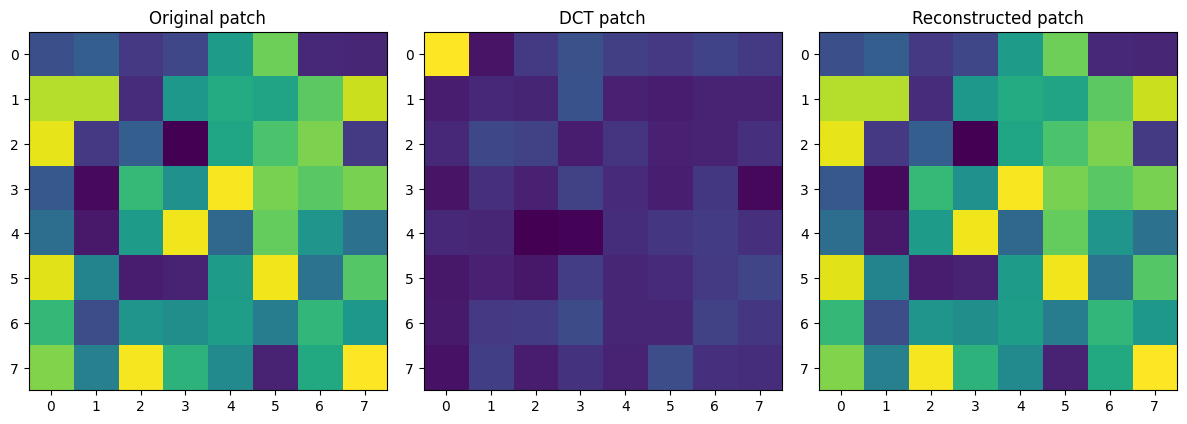

In [213]:
@channels_handler(3)
def direct_dct2d(patch:np.ndarray, matrix_basis:np.ndarray) -> np.ndarray:
    N, M, C = patch.shape
    assert N == M, "Patch must be square"
    assert matrix_basis.shape == (N, N, N, N), f"matrix_basis must be {N}x{N}x{N}x{N}, but got {matrix_basis.shape}"

    # inputs        (N, N, C)
    # filters (N, N, N, N, 1)
    inputs = patch
    filters = matrix_basis[..., np.newaxis]

    out = np.zeros((N, N, C), dtype=np.float64)
    for u in range(N):
        for v in range(N):
            # compute the 2D DCT of the patch at position (u, v)
            F_u_v = np.sum(np.multiply(inputs, filters[u, v]), axis=(0, 1))
            out[u, v] = F_u_v

    return out

@channels_handler(3)
def inverse_dct2d(patch_dct2d:np.ndarray, matrix_basis:np.ndarray) -> np.ndarray:
    N, M, C = patch_dct2d.shape
    assert N == M, "Patch must be square"
    assert matrix_basis.shape == (N, N, N, N), f"matrix_basis must be {N}x{N}x{N}x{N}, but got {matrix_basis.shape}"

    # inputs  (N, N, 1, 1, C)
    # filters (N, N, N, N, 1)
    inputs  = patch_dct2d[:, :, np.newaxis, np.newaxis, :]
    filters = matrix_basis[..., np.newaxis]

    # multiply each component
    # (N, N, N, N, C)
    patch_components = np.multiply(inputs, filters)

    # sum all components along the first 2 dimensions
    # (N, N, C)
    patch = np.sum(patch_components, axis=(0, 1))

    return patch

N = 8
dct2d_basis = construct_dct2d_basis(N)
if 1:
    # generate a random (N, N, 3) patch uint8
    patch = np.random.randint(0, 255, size=(N, N, 1), dtype=np.uint8)
else:
    patch = img_patches[16, 16, :, :]


x = patch
debug_ndarray(x, "x")
x_c = x
#x_c = centering(x)

x_dct = direct_dct2d(x_c, dct2d_basis)
debug_ndarray(x_dct, "x_dct")

x_recon = inverse_dct2d(x_dct, dct2d_basis)
#x_recon = decentering(x_recon)
x_recon = convert_to_u8(x_recon)
debug_ndarray(x_recon, "x_recon")


fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(x)
axs[0].set_title("Original patch")

axs[1].imshow(x_dct)
axs[1].set_title("DCT patch")

axs[2].imshow(x_recon)
axs[2].set_title("Reconstructed patch")

fig.tight_layout()
plt.show()

assert x.shape == x_recon.shape, f"Reconstructed patch must have the same shape as the original patch:({x.shape} vs {x_recon.shape})"
assert np.allclose(x, x_recon), "Reconstructed patch must be equal to the original patch"
assert np.abs(x - x_recon).sum() == 0, f"Reconstructed error must be 0: {np.abs(x - x_recon).sum()}"

## 2.3 Quantification

La quantification est l’étape qui permet de gagner le plus de place (la DCT n’effectue aucune compression). La
DCT a retourné, pour chaque bloc, une matrice de 8 × 8 nombres. La quantification consiste à diviser point à point
cette matrice par une matrice de quantification également 8 × 8. Soit Q la matrice de quantification. Le bloc 8 × 8
après compression sera obtenu par:
$$ \hat{F}(u, v) = \text{round} \left(\frac{F(u, v)}{Q(u, v)} \right) $$

Le but est d’atténuer les hautes fréquences car l’œil humain y est très peu sensible. Ces fréquences ont des amplitudes
faibles, et elles sont souvent ramenées à 0 après la quantification. Ces coefficients sont situés dans la matrice en bas à
droite. Le but va être de ne garder que quelques informations essentielles (concentrées dans le coin en haut à gauche)
pour représenter le bloc. Le reste de la matrice sera essentiellement composée de 0, ce qui va permettre d’utiliser un
codage RunLength afin de gagner de la place.

Les matrices de quantification sont les éléments centraux de la compression avec pertes parce que c’est la quantification qui permet de régler les pertes, et donc le taux de compression. En toute rigueur, ces matrices devraient être
calculées pour chaque image, en tenant compte du taux de compression désiré et des propriétés de l’image et de l’œil.
En pratique, ce calcul est complexe, et l’on pourra dans ce projet utiliser les matrices pré-calculées.

Pour la quantification d’une composante RGB ou de la composante luminance, la matrice Q est:
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline 16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 \\
\hline 12 & 12 & 14 & 19 & 26 & 58 & 60 & 55 \\
\hline 14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 \\
\hline 14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 \\
\hline 18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 \\
\hline 24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 \\
\hline 49 & 64 & 78 & 87 & 103 & 121 & 120 & 101 \\
\hline 72 & 92 & 95 & 98 & 112 & 100 & 103 & 99 \\
\hline
\end{array}

Pour la quantification de la composante chrominance, la matrice Q est:
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline 17 & 18 & 24 & 47 & 99 & 99 & 99 & 99 \\
\hline 18 & 21 & 26 & 66 & 99 & 99 & 99 & 99 \\
\hline 24 & 26 & 56 & 99 & 99 & 99 & 99 & 99 \\
\hline 47 & 66 & 99 & 99 & 99 & 99 & 99 & 99 \\
\hline 99 & 99 & 99 & 99 & 99 & 99 & 99 & 99 \\
\hline 99 & 99 & 99 & 99 & 99 & 99 & 99 & 99 \\
\hline 99 & 99 & 99 & 99 & 99 & 99 & 99 & 99 \\
\hline 99 & 99 & 99 & 99 & 99 & 99 & 99 & 99 \\
\hline
\end{array}



In [214]:
Q_Y   = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])
Q_R = Q_Y
Q_G = Q_Y
Q_B = Q_Y

Q_Cr = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])
Q_Cb = Q_Cr

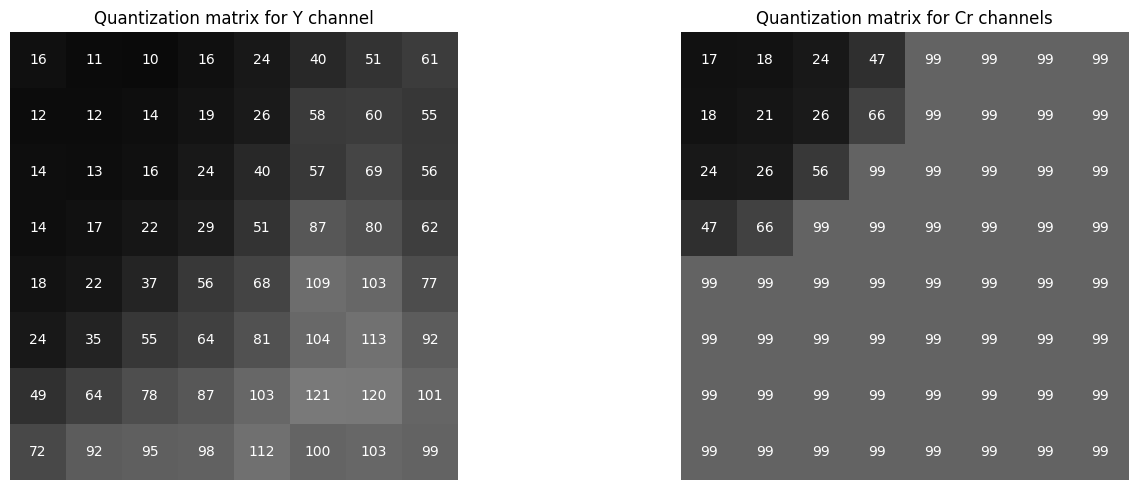

In [215]:
# plot the quantization matrices as images
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#TODO
axes[0].imshow(Q_Y, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(Q_Cr, cmap='gray', vmin=0, vmax=255)


axes[0].set_title("Quantization matrix for Y channel")

axes[1].set_title("Quantization matrix for Cr channels")


# add value on each cell
for i in range(8):
    for j in range(8):
        axes[0].text(j, i, Q_Y[i, j], ha="center", va="center", color="w")
        axes[1].text(j, i, Q_Cr[i, j], ha="center", va="center", color="w")
for ax in axes:
    ax.axis('off')
fig.tight_layout()
plt.show()



### 2.4 Quantification avec facteur de qualité

En pratique, on modifie la quantification avec un facteur de qualité.

Soit $fq$ le facteur de qualité (entre 1 et 100), définir

$$s(fq)=\begin{cases}
    5000 / fq, & \text{si $fq<50$}.\\
    200 − 2 fq , & \text{sinon}.
  \end{cases}$$

et puis calculer la nouvelle matrice de quantification:

$$Q_2(fq, Q) = floor\left(\frac{s(fq) \times Q + 50}{100}\right)$$

Remarque:
On retrouve la matrice de quantification original dans le cas où $fq=50$.
En particulier, Q2(50, Q) = Q

In [216]:
def Q2(fq: int, Q: np.ndarray) -> np.ndarray:
    assert 1 <= fq <= 100
    #TODO
    if fq < 50:
        sfq = 5000/fq
    else:
        sfq = 200 - 2*fq 

    return np.floor((sfq*Q+50)/100)
        

assert (Q2(50, Q_Y) == Q_Y).all(), "Q2(50, Q_Y) must be equal to Q_Y"

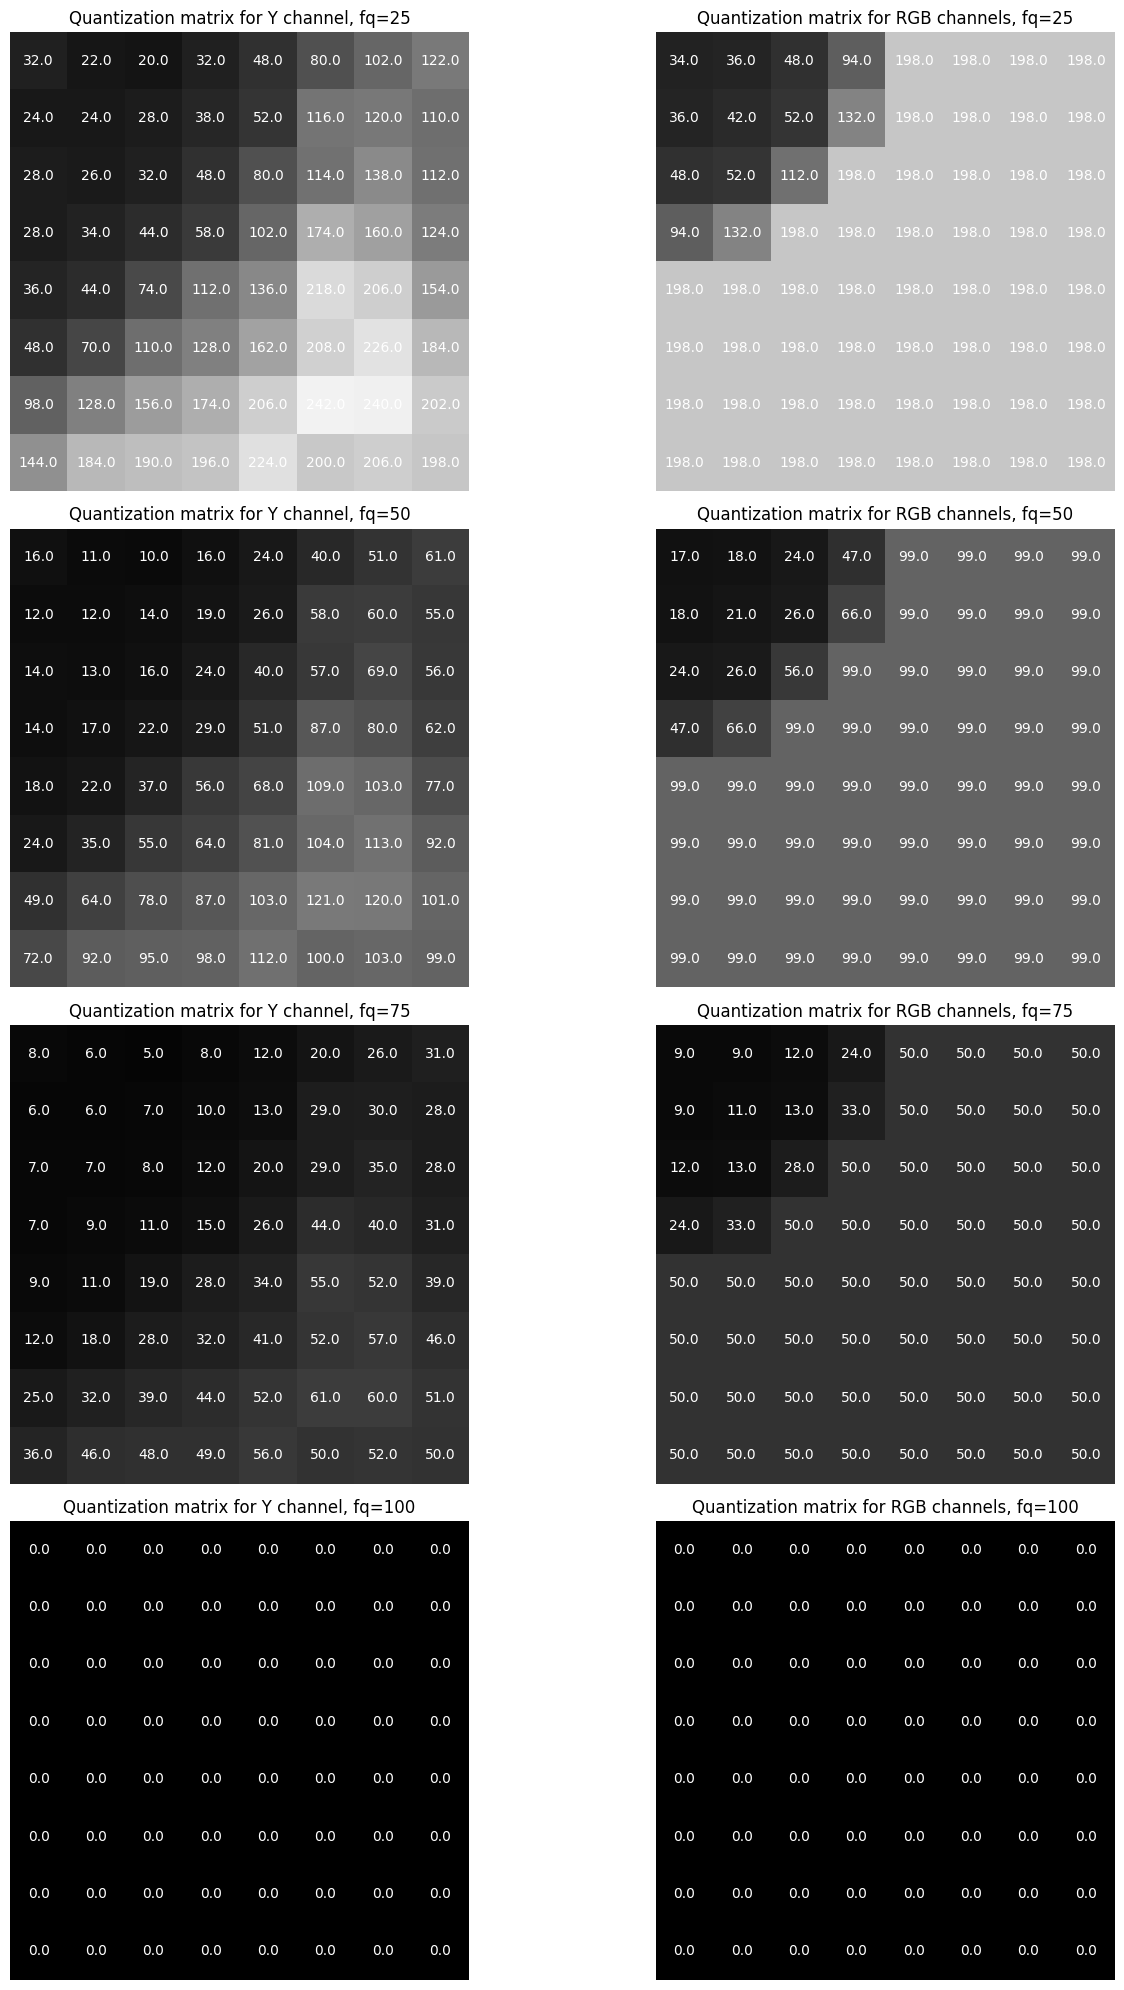

In [217]:
# plot the quantization matrices as images
factors = [25, 50, 75, 100]
fig, axes = plt.subplots(len(factors), 2, figsize=(15, 5*len(factors)))
for i, fq in enumerate(factors):
    Q2_Y = Q2(fq, Q_Y)
    Q2_RGB = Q2(fq, Q_Cb)
    axes[i, 0].imshow(Q2_Y, cmap='gray', vmin=0, vmax=255)
    axes[i, 0].set_title(f"Quantization matrix for Y channel, fq={fq}")
    axes[i, 1].imshow(Q2_RGB, cmap='gray', vmin=0, vmax=255)
    axes[i, 1].set_title(f"Quantization matrix for RGB channels, fq={fq}")

    # remove axis
    for ax in axes[i]:
        ax.axis('off')

    # add value on each cell
    for x in range(8):
        for y in range(8):
            axes[i, 0].text(y, x, Q2_Y[x, y], ha="center", va="center", color="w")
            axes[i, 1].text(y, x, Q2_RGB[x, y], ha="center", va="center", color="w")


fig.tight_layout()
plt.show()

In [218]:
def get_quantization_matrix(fq: int, name:str='Y') -> List[np.ndarray]:
    '''
    name: Y, R, G, B, Cb or Cr
    returns the quantifization matrix for the "name" channel
    raises a ValueError if name is different
    '''
    #TODO
    if name == 'Y':
        return Q2(fq, Q_Y)
    elif name == 'R':
        return Q2(fq, Q_R)
    elif name == 'G':
        return Q2(fq, Q_G)
    elif name == 'B':
        return Q2(fq, Q_B)
    elif name == 'Cb':
        return Q2(fq, Q_Cb)
    elif name == 'Cr':
        return Q2(fq, Q_Cr)


get_quantization_matrix(fq=50, name='Y')

array([[ 16.,  11.,  10.,  16.,  24.,  40.,  51.,  61.],
       [ 12.,  12.,  14.,  19.,  26.,  58.,  60.,  55.],
       [ 14.,  13.,  16.,  24.,  40.,  57.,  69.,  56.],
       [ 14.,  17.,  22.,  29.,  51.,  87.,  80.,  62.],
       [ 18.,  22.,  37.,  56.,  68., 109., 103.,  77.],
       [ 24.,  35.,  55.,  64.,  81., 104., 113.,  92.],
       [ 49.,  64.,  78.,  87., 103., 121., 120., 101.],
       [ 72.,  92.,  95.,  98., 112., 100., 103.,  99.]])

# 3. Encodeur d'entropy

L'encodeur d'entropy est composé de trois étapes:
* Parcours en zigzag
* Codage par plages / (RLE) Run Length Encoding
* Codage de Huffman

Cet étape permet de compresser (sans perte) les blocs quantifiées.

**Remarque:**
JPEG distingue le bloc DC (Direct Current) et les blocs AC (Alternating Current)
qui correspondent respectivement au premier coefficient DCT (u=v=0) et aux autres coefficients DCT.


## 3.1 Parcours en zigzag

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0140366421004205-gr2.jpg">

A ce stade, on a une matrice `(N, N)` de coefficients entiers.
Le but est de la transformer en un vecteur une dimension de taille `N*N`.
Pour cela, on doit parcourir et collecter tous les coefficients de la matrice.

Le parcours le plus simple est le parcours en ligne ou le parcours en colonne.
Exemple: avec une matrice 3x3 on a les parcours suivants:

ligne: `(0, 0)→(0, 1)→(0, 2)→(1, 0)→(1, 0)→(1, 0)→(2, 0)→(2, 1)→(2, 2)`

colonne: `(0, 0)→(1, 0)→(2, 0)→(0, 1)→(1, 1)→(2, 1)→(0, 2)→(1, 2)→(2, 2)`


Cependant, ce parcours n’est pas optimal pour la compression car il ne permet pas de regrouper les coefficients nuls.
Comme dit dans la section précédente, après la quantification, beaucoup de coefficients de la matrice Fˆ sont nuls
et ils localisés en bas à droite de cette matrice.
Le nombre de bits moyen de ces coefficients est donc très réduit.
Afin d’exploiter cette propriété, le bloc 8 × 8 sera lu avec un parcours zigzag (voir Figure) afin de construire de longues plages
de 0 qui par la suite optimisera au mieux l’utilisation d’un RLE sur le symbole 0.

**Principe**:
Il consiste à parcourir les coefficients de la matrice en diagonale, en commençant par le coin en haut à gauche, et en alternant les diagonales de gauche à droite et de droite à gauche.
Exemple: avec une matrice 3x3 on a les parcours suivants:

zigzag: `(0, 0)→(0, 1)→(1, 0)→(2, 0)→(1, 1)→(0, 2)→(1, 2)→(2, 1)→(2, 2)`

```python
(0, 0)                 # premiere diagonale  - gauche à droite
(0, 1) (1, 0)          # deuxieme diagonale  - droite à gauche
(2, 0) (1, 1) (0, 2)   # troisieme diagonale - gauche à droite
(1, 2) (2, 1)          # quatrieme diagonale - droite à gauche
(2, 2)                 # cinquieme diagonale - gauche à droite
```

Dans un premier temps, implémenter la fonction `zigzag_indexs`.
Celle ci prend en entrée `size` la taille d'une matrice matrice `size` × `size`
et qui renvoie un array de taille `(size*size, 2)` contenant les coordonnées
des éléments de la matrice parcourue en zigzag.

exemples:
```python
size = 2
[[0, 0], [0, 1], [1, 0], [1, 1]]

size = 3
[[0, 0], [0, 1], [1, 0], [2, 0], [1, 1], [0, 2], [1, 2], [2, 1], [2, 2]]
    
size=4
[[0, 0], [0, 1], [1, 0], [2, 0], [1, 1], [0, 2], [0, 3], [1, 2], [2, 1], [3, 0], [3, 1], [2, 2], [1, 3], [2, 3], [3, 2], [3, 3]]
```

In [219]:
def zigzag_indexs(size:int) -> np.ndarray:
    '''
    Construct the zigag indexs of a `(size, size)` square matrix .
    Return
        shape = (size*size, 2)
    '''
    out = np.zeros((size*size, 2), dtype=np.int32)

    # Initialize the starting position
    row, col = 0, 0

    # Loop through the array and fill in the zigzag pattern
    for i in range(size * size):
        out[i] = (row, col)

        # Check if we need to change direction
        if (row + col) % 2 == 0:
            if col == size - 1: #On va en bas
                row+=1
            elif row == 0: #On va à droite
                col+=1
            else: #On va en haut à droite
                row-=1
                col+=1
        else:
            if row == size - 1:  #On va à droite
                col+=1
            elif col == 0: #On va en bas
                row+=1
            else: #On va en bas à gauche
                row+=1
                col-=1

    return out


N = 4
z_indices = zigzag_indexs(N)
display(z_indices)

array([[0, 0],
       [0, 1],
       [1, 0],
       [2, 0],
       [1, 1],
       [0, 2],
       [0, 3],
       [1, 2],
       [2, 1],
       [3, 0],
       [3, 1],
       [2, 2],
       [1, 3],
       [2, 3],
       [3, 2],
       [3, 3]])

Créer la fonction `zigzag_matrix` qui renvoie une matrice de taille `size` × `size`
avec un motif de zigzag.
Utiliser la fonction `zigzag_indexs` précédente.

exemples:
```python

size = 3
array([[0, 1, 5],
       [2, 4, 6],
       [3, 7, 8]])

size = 4
array([[ 0,  1,  5,  6],
       [ 2,  4,  7, 12],
       [ 3,  8, 11, 13],
       [ 9, 10, 14, 15]])

size = 5
array([[ 0,  1,  5,  6, 14],
       [ 2,  4,  7, 13, 15],
       [ 3,  8, 12, 16, 21],
       [ 9, 11, 17, 20, 22],
       [10, 18, 19, 23, 24]])
```     

In [220]:
def zigzag_matrix(size:int) -> np.ndarray:
    '''
    Construct a `(size, size)` square matrix with zigzag pattern.
    '''
    #TODO
    zigzag = zigzag_indexs(size)
    zm = np.zeros((size, size))
    
    for i in range(len(zigzag)):
        zm[zigzag[i][0]][zigzag[i][1]] = i
        
    return zm.astype(int)

N = 5
zm = zigzag_matrix(N)
display(zm)

array([[ 0,  1,  5,  6, 14],
       [ 2,  4,  7, 13, 15],
       [ 3,  8, 12, 16, 21],
       [ 9, 11, 17, 20, 22],
       [10, 18, 19, 23, 24]])

Implémenter la fonction `encode_zigzag`  et `decode_zigzag`.

`encode_zigzag` prend en entrée un np.ndarray qui a un minimum de 2 dimensions (`size`,`size`, *) et qui renvoie un np.ndarray de 1 dimension (size x size, *).

`decode_zigzag` prend en entrée un np.ndarray de 1 dimension (`size`*`size`, *) et qui renvoie un np.ndarray qui a un minimum de 2 dimensions (`size`,`size`, *).

Utilise dans les deux fonctions la fonction `zigzag_indexs` précédente.

Pour tester ces fonctions, vous pouvez créer une matrice au motif de zigzag avec la fonction `zigzag_matrix` pour une `size` donnée et vérifier que son encodage correspond bien à un array une dimension contenant les nombres de 0 à `size`*`size`-1.

`encode_zigzag(zigzag_matrix(size)) == np.array([0, 1, ..., size*size-1])`.

Vériier que `decode_zigzag(encode_zigzag(mat)) == mat` pour toutes les matrices `mat` générées.

In [221]:
def encode_zigzag(arr: np.ndarray) -> np.ndarray:
    '''
    Encode a 2D array using zigzag pattern.
    Input array must be a square matrix of size `(size,size)`
    Return a 1D array of length `(size*size)`
    '''
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
    N, M = arr.shape[:2]
    assert N == M, "arr[:2] must be a square matrix"
    
    #TODO
    # out = np.zeros(N*M, dtype=arr.dtype)
    # zig_i = zigzag_indexs(M)
    # for i in range(M*N):
    #     
    index_N, index_M = np.transpose(zigzag_indexs(M))
    return arr[index_N, index_M]



def decode_zigzag(arr: np.ndarray) -> np.ndarray:
    '''
    Decode a 1D array of length `(size*size)` using zigzag pattern.
    Return a 2D array of size `(size,size)`
    '''
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
    total = arr.shape[0]
    size = int(len(arr) ** 0.5)
    assert total == size * size, f"array is not a perfect square {size*size} != {total}"

    #TODO
    out = np.zeros((size, size), dtype=arr.dtype)

    index_N, index_M = np.transpose(zigzag_indexs(size))

    for i in range(size * size):
        out[index_N[i], index_M[i]] = arr[i]

    return out



# replace int with alphabet
N = 3
data = zigzag_matrix(N)

print('data :', data, sep='\n')

# encode
encoded = encode_zigzag(data)
print('encoded :', encoded, sep='\n')

assert encoded.shape == (N*N,) and (encoded == np.arange(N*N)).all()

# decode
decoded = decode_zigzag(encoded)
print('decoded :', decoded, sep='\n')
assert (decoded == data).all(), "decoded data is not the same as original data"



data :
[[0 1 5]
 [2 4 6]
 [3 7 8]]
encoded :
[0 1 2 3 4 5 6 7 8]
decoded :
[[0 1 5]
 [2 4 6]
 [3 7 8]]


In [222]:
x = "WWWWWWWWWWWWBWWWWWWWWWWWWBBBWWWWWWWWWWWWWWWWWWWWWWWWBWWWWWWWWWWWWWW"
','.join(list(c for c in x))

'W,W,W,W,W,W,W,W,W,W,W,W,B,W,W,W,W,W,W,W,W,W,W,W,W,B,B,B,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,B,W,W,W,W,W,W,W,W,W,W,W,W,W,W'

## 3.2 RLE

Une fois le vecteur contenant les `N*N` valeurs du bloc construit,
il faut effectuer un codage RLE (Run Length Encoding).

Le codage RLE consiste à remplacer une plage de symboles identiques par un seul symbole suivi de la longueur de cette plage.

Par exemple:
`(W,W,W,W,W,W,W,W,W,W,B,B,B,W,W,W,W,W,W,W,B,B,W,B,W,W,W)`

devient
`(W,10,B,3,W,7,B,2,W,1,B,1,W,3)`

On peut aussi choisir d'encoder seulement un seul symbole.
Dans ce cas, on remplace les plages de symboles par un autre symbole `escape` suivi de la longueur de la plage.
En reprenant l'exemple précédent, on obtient et en choisissant d'encoder

uniquement le symbole `W`:
`(escape,10,B,B,B,escape,7,B,B,escape,1,B,escape,3)`

uniquement le symbole `B`:
`(W,W,W,W,W,W,W,W,W,W,escape,3,W,W,W,W,W,W,W,escape,2,W,escape,1,W,W,W)`

**Implémentation:**

Pour JPEG, on réalise le codage RLE sur le symbole `0` uniquement.
En effet, le vecteur obtenu après zigzag est constitué de longue plages de 0 (suite à la quantification).
Dès qu’une plage de 0 est détectée, il faut préciser la longueur de cette plage, précédée du symbol `257`.

*Remarque*: `257` est le symbole `EOB` (End Of Block) qui indique la fin du bloc.

Réaliser la fonction `encode_rle` qui prend en entrée `data` une liste ou (np.ndarray de 1 dimension),
le `symbol` à encoder ainsi que la valeur `escape` utilisée pour coder les plages de `symbol` et qui renvoie un array d'une dimension dont les plage de `symbol` sont remplacées par un symbole suivi de la longueur de cette plage `(escape, longueur)`.

La fonction `decode_rle` décodera un vecteur encodé à l'aide de la fonction `encode_rle`.

Vérifier que `decode_rle(encode_rle(data, symbol, escape), symbol, escape) == data`.



In [223]:
def encode_rle(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Encode a list of values using run length encoding
    when `symbol` is encountered,
    the next value is `escape` followed by the number of `symbol`.
    '''
    #TODO
    out = []
    count = 0
    for i in data:
        if i == symbol:
            count += 1
        else:
            # flush the count
            if count > 0:
                out.append(escape)
                out.append(count)
                count = 0
            out.append(i)
    # further flush the count if any left
    if count > 0:
        out.append(escape)
        out.append(count)
    return np.array(out)

    #     if i == symbol:
    #         if count == 0:
    #             data_encode_rle.append(escape)
    #         count+=1
    #     else:
    #         if count!= 0:
    #             data_encode_rle.append(count)
    #             count = 0
    #         data_encode_rle.append(i)
    # if count != 0:
    #     data_encode_rle.append(count)
    # return np.array(data_encode_rle)
 

def decode_rle(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Decode a list of values using run length encoding of caracter `symbol`
    '''
    #TODO
    data_decode_rle = []
    i = 0
    while i < len(data):
        if data[i] == escape:
            for j in range(data[i+1]):
                data_decode_rle.append(symbol)
            i+=2
        else:
            data_decode_rle.append(data[i])
            i+=1
            
    return np.array(data_decode_rle)



data = np.array([0, 1, 0, 0, 0, 0, 0, 2, 0])
print('Data    : ', data)

data_enc = encode_rle(data)
print('Encoded : ', data_enc)

data_dec = decode_rle(data_enc)
print('Decoded : ', data_dec)

assert (data_dec == data).all(), "decoded data is not the same as original data"


Data    :  [0 1 0 0 0 0 0 2 0]
Encoded :  [257   1   1 257   5   2 257   1]
Decoded :  [0 1 0 0 0 0 0 2 0]


## 3.3 Codage de Huffman

Le codage de Huffman est une méthode de codage entropique à longueur variable qui associe une valeur spécifique à un code unique.
Le code Huffman est connu comme un code préfixe car aucun code n'est le préfixe ou le début d'un mot codeur plus long.
Cette propriété rend le code Huffman uniquement décodable.

Une fois les vecteurs ecodant le RLE codés, il faut effectuer un codage de Huffman pour les Vrlc (un dictionnaire
pour tous les Vrlc de tous les blocs).

Premièrement, il faut compter le nombre d'occurences de chaque symbole dans le vecteur encodé.
Implémenter la fonction `count_symbols` qui prend en entrée un vecteur encodé et qui renvoie un dictionnaire dont les clés sont les symboles et les valeurs sont le nombre d'occurences de ces symboles.

In [224]:
def count_symbols(data:list) -> Dict[Any, int]:
    '''
    Compute the frequency of each value in the list
    '''
    #TODO
    dico = {}
    for symbol in data:
        if symbol in dico:
            dico[symbol] += 1
        else:
            dico[symbol] = 1
    return dico


freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)

{0: 4, 1: 3, 2: 2, 3: 1}


**Représentation d'un arbre binaire**

En Python on peut représenter un arbre binaire de la manière suivante sans faire appel à des modules externes.

On peut utiliser un tuple de la forme `(count, fils_gauche, fils_droit)` pour les noeuds internes.

Les feuilles sont représentées par un tuple de la forme `(count, valeur_feuille)`.
Par exemple pour representé l'arbre ci-dessous,
```
        (c0)
       /     \
      /       \
    (c1)       (c2)
    /         /    \
(c3):v3   (c4):v4  (c5):v5
```
on peut utiliser le tuple suivant:
```python
(c0, (c1, (c3, v3)), (c2, (c4, v4)), (c5, v5))
```

**Arbre de Huffman**

Pour obtenir le code de Huffman, il faut construire un arbre (binaire) de Huffman.
Cet arbre est construit à partir d'une liste de feuilles (symboles) et de noeuds internes (somme des poids des fils).
Chaque noeud est associé à une valeur qui est la somme des valeurs des fils.
Les feuilles correspondent aux symboles et sont associées à leur nombre d'occurences dans le vecteur.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

*Principe:*

Imaginons que nous ayons la phrase  à encoder en utilisant l'algorithme de Huffman.
Tout d'abord, nous devons déterminer le nombre d'occurrences de chaque caractère dans la phrase.
Par exemple, le caractère "h" apparaît deux fois et il y a sept espaces.
Chaque caractère sera représenté par une feuille de l'arbre et aura un poids égal à son nombre d'occurrences.

L'arbre de Huffman est créé en associant les deux nœuds de poids le plus faible à chaque étape pour créer un nouveau nœud dont le poids est égal à la somme des poids de ses fils.
Ce processus est répété jusqu'à ce qu'il ne reste plus qu'un seul nœud, qui est la racine de l'arbre.

On obtient alors un arbre pour la phrase `"this is an example of a huffman tree"`
```python
(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))
```


In [225]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''

    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))

    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])
    
    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]

        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])


    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Table de codage de Huffman**

Une fois l'arbre de Huffman construit, il faut construire une table de codage de Huffman.
Cette table est un dictionnaire dont les clés sont les symboles et les valeurs sont les codes associés à ces symboles.

Les branches partant vers la gauche sont associées au code 0 et les branches partant vers la droite sont associées au code 1.
Pour cela, il faut parcourir l'arbre de Huffman et associer à chaque symbole un code binaire.

Implémenter la fonction `bintree_to_table` qui prend en entrée un arbre binaire et qui renvoie une table de codage de Huffman.

Visualizer la table obtenue pour `data` à l'aide de la fonction `display_huffman_table`.

In [226]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)


def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)

    return table


sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)



Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


Créer une fonction `construct_huffman_table` qui prend en entrée un vecteur `data`
et qui renvoie la table de codage de Huffman associée à ce vecteur.
Utiliser les fonction
* `count_symbols`
* `compute_huffman_tree`
* `bintree_to_table`


In [227]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(counts)
    table = bintree_to_table(tree)
    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print(table)

{'t': '0000', 'h': '0001', 'i': '0010', 's': '0011', ' ': '0100', 'a': '0101', 'n': '0110', 'e': '0111', 'x': '1000', 'm': '1001', 'p': '1010', 'l': '1011', 'o': '1100', 'f': '1101', 'u': '1110', 'r': '1111'}


Implémenter la fonction `encode_huffman` qui prend en entrée un vecteur `data` et une table de codage de Huffman `table`
et qui renvoie le vecteur encodé à l'aide de la table de codage de Huffman.

Implémenter la fonction `decode_huffman` qui prend en entrée un vecteur encodé `data` et une table de codage de Huffman `table`
et qui renvoie le vecteur décodé à l'aide de la table de codage de Huffman.
Pour décoder une chaine de caractères codée avec un codage de Huffman,
on utilise la propriété suivante:
Le codage de Huffman est un codage prefixe, c’est-à-dire que le code d’un symbole ne peut pas être un préfixe du
code d’un autre symbole.
Ainsi, pour décoder une chaine de caractères, il suffit de lire le premier symbole, puis de
rechercher dans le dictionnaire le symbole correspondant. Une fois le symbole trouvé, on peut supprimer ce symbole
de la chaine de caractères, et recommencer le processus jusqu’à ce que la chaine de caractères soit vide.

In [228]:
def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)

assert (data == decoded).all(), "decoded data is not the same as original data"


Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1101111101101101101100011001010010
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


# 4. Implémentation d’un codeur/décodeur JPEG simplifié


**Conseil** :
* Calculer, afficher et interpréter le résultat de différentes étapes (par exemple, le DCT ou la quantification
de différents blocs).
* Calculer le taux de compression, les erreurs, le PSNR.
* Découper le programme en de différentes fonctions.


## 4.1 Encodage

* Découpage en bloc de taille 8 × 8
* Centrage, DCT et quantification de chaque bloc
* RunLength coding
* Codage de Huffman

In [229]:
def encode_matrix(mat:np.ndarray, patch_size:int, Q:np.ndarray, matrix_basis:np.array) -> Tuple[str, dict]:
    assert mat.ndim == 2, "mat must be a 2D array"
    assert mat.shape[0] % patch_size == 0, "mat rows must be a multiple of patch_size"
    assert mat.shape[1] % patch_size == 0, "mat cols must be a multiple of patch_size"
    assert Q.shape == (patch_size, patch_size), "Q must be a 2D array of shape (patch_size, patch_size)"
    assert list(dct2d_basis.shape) == [patch_size]*4, "dct2d_basis must be a 4D array of shape (patch_size, patch_size, patch_size, patch_size)"
    
    # etape 1: get patches. shape (rows*cols, N, N)
    r,c = img.shape[:2]

    patches = serialize_patches(img, patch_size, True) #TODO

    encoded = []
    # loop trough each patch shape (N, N)
    for p in patches:
        # etape 2: DCT-2D: (N, N)
        p = construct_dct2d_basis(patch_size) #TODO
        # etape 3: Quantification (N, N)
        p = np.round(np.divide(p,Q)) #TODO
        # detect nan
        if np.isnan(p).any():
            raise ValueError("Quantification matrix Q must not contain nan")
        # etape 4: zigzag encoding (2D -> 1D): (N*N)
        p = encode_zigzag(p) #TODO
        encoded.extend(p)


    # etape 5: '0' RLE
    encoded: list = encode_rle(encoded) #TODO

    # etape 6: Huffman
    mat_table: dict = construct_huffman_table(list) #TODO
    mat_encoded: str = encode_huffman(list, dict) #TODO

    return mat_encoded, mat_table

In [230]:
def encode(img, patch_size:int=8, fq:int=50, YCbCr:bool=True, center:bool=True) -> Dict[str, Any]:
    assert len(img.shape) in [2, 3], "image must be 2D or 3D"
    squueze = len(img.shape) == 2
    if squueze:
        img = img[:, :, np.newaxis]
    img_height, img_width, num_channels = img.shape
    rows = img_height // patch_size
    cols = img_width // patch_size
    if num_channels == 1:
        channels_name = ['Gray']
    else:
        channels_name = ['Y', 'Cb', 'Cr'] if YCbCr else ['R', 'G', 'B']

    dct2d_basis = construct_dct2d_basis(patch_size)

    # etape 0 (option): convert to YCbCr
    if YCbCr:
        img = convert_rgb_to_ycbcr(img)
    # centering
    if center:
        img = centering(img)

    channels = []
    for ch in range(num_channels):
        mat = img[:, :, ch]
        Q = get_quantization_matrix(fq, name=channels_name[ch])
        mat_encoded, mat_table = encode_matrix(mat, patch_size, Q, dct2d_basis)
        channels.append({
            'name': channels_name[ch],
            'encoded': mat_encoded,
            'table': mat_table,
            'Q': Q,
        })


    return {
        'channels': channels,
        'metadata':{
            'patch_size': patch_size,
            'width': img_width,
            'height': img_height,
            'rows': rows,
            'cols': cols,
            'num_channels': num_channels,
            'YCbCr': YCbCr,
            'center': center,
        }
    }

img_enc: dict = encode(img, patch_size=8, fq=50, YCbCr=True, center=True)
print(img_enc['metadata'])


# number of bits in original image
H, W, C = img.shape
num_bits_org = H * W * C * 8
print('Number of bits (original) :', num_bits_org)

# number of bits in encoded image
num_bits = sum(len(c['encoded']) for c in img_enc['channels'])
print('Number of bits (encoded)  :', num_bits)

# compute compression ratio
compression_ratio = num_bits_org / num_bits
print('Compression ratio:', round(compression_ratio, 2))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 4.2 Decodage

* Les fonctions inverses de chacun des points précédents

Le décodage d’une data unit va défaire tous les étapes précédentes les unes après les autres. La première étape
consistera à décoder le code de Huffman de la data unit afin de reconstruire le vecteur Vrlc. De là, on peut reconstruire
les 64 valeurs de bloc 8 × 8, puis inverser l’opération de quantification et de DCT.

In [ ]:
def decode_matrix(encoded:str, table:dict, patch_size:int, rows:int, cols:int, height:int, width:int, matrix_basis:np.array, Q:np.ndarray) -> np.ndarray:
    # huffman decode
    encoded = decode_huffman(encoded, table) #TODO

    # rle decode (output is 1D)
    encoded = decode_rle(encoded, 0, escape=0) #TODO

    # reshape to (rows*cols, patch_size*patch_size)
    encoded_patchs = #TODO

    serialized_list = []
    for patch in encoded_patchs:
        # zigzag decoding from (N*N) to (N, N)
        patch = decode_zigzag() #TODO

        # dequantification
        patch = #TODO

        # inverse DCT-2D
        patch = inverse_dct2d() #TODO
        #patch = convert_to_u8(patch)

        serialized_list.append(patch)

    # un-serialize patches
    serialized_array = np.array(serialized_list)
    mat = deserialize_patches(serialized_array, height, width, 8, True) #TODO

    return mat

SyntaxError: invalid syntax (3802496095.py, line 9)

In [ ]:
def decode(img_enc:dict):
    '''
    Decode a dictionary containing the encoded image data into the original image
    '''
    # create DCT-2D matrix basis (N, N, N, N)
    dct2d_basis = construct_dct2d_basis(img_enc['metadata']['patch_size'])

    # decode each channel separately
    mat_channels = []
    for channel in img_enc['channels']:
        mat = decode_matrix(
            channel['encoded'],
            channel['table'],
            img_enc['metadata']['patch_size'],
            img_enc['metadata']['rows'],
            img_enc['metadata']['cols'],
            img_enc['metadata']['height'],
            img_enc['metadata']['width'],
            dct2d_basis,
            channel['Q']
        )
        mat_channels.append(mat)

    # merge matrices into a single image
    img = np.stack(mat_channels, axis=2)

    # decentering
    if img_enc['metadata']['center']:
        img = decentering(img)

    # etape 0 (option): convert to RGB
    if img_enc['metadata']['YCbCr']:
        img = convert_ycbcr_to_rgb(img)

    img = convert_to_u8(img)

    return img


def compute_psnr(img1, img2, max_val:int=255):
    '''
    Compute PSNR between two images
    '''
    mse = np.mean(np.square(img1 - img2))
    if mse == 0:
        return 100
    return 20 * np.log10(max_val / np.sqrt(mse))


img_jpeg = decode(img_enc)
debug_ndarray(img_jpeg, "img_jpeg")
show(img_jpeg)

# compute PSNR
psnr = compute_psnr(img, img_jpeg)
print('PSNR:', psnr)

# compute and show error
error = np.abs(img - img_jpeg).mean(axis=2)
print('Error:', error.sum())
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(img_jpeg)
ax[2].imshow(error, cmap='gray', vmin=0, vmax=255)
plt.show()



NameError: name 'img_enc' is not defined

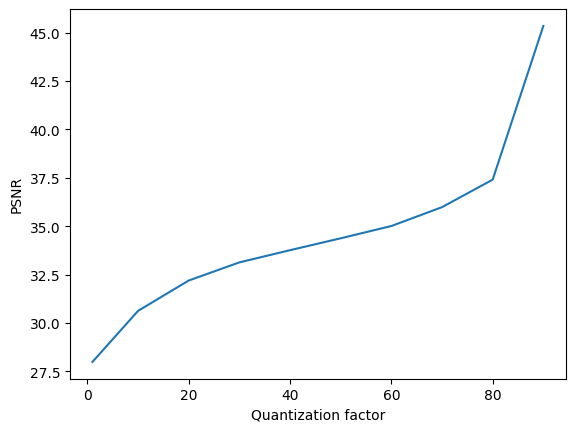

In [ ]:
psnrs = []
factors = np.linspace(1, 90, num=10, dtype=int)
for fq in factors:
    img_enc = encode(img, patch_size=8, fq=fq, YCbCr=True, center=True)
    img_jpeg = decode(img_enc)
    psnr = compute_psnr(img, img_jpeg)
    psnrs.append(psnr)

plt.plot(factors, psnrs)
plt.xlabel('Quantization factor')
plt.ylabel('PSNR')
plt.show()


# Résumé du TP

## Qu'est ce qu'un décorateur ?
Un décorateur 
## Les grandes étapes de la compression/décompression d'images

### I – Compression d'une Image 
Nous partons d'une image d'entrée au format RGB (codé sur trois octets).

#### 1 – Conversion en luminance 
L'image est convertie au format YCbCr, correspondant à la luminance Y (intensité du pixel en niveau de gris) et deux chrominances (Une bleue Cb ainsi qu'une rouge Cr). Ce format nous permet de sous-échantilloner les canaux de chrominance par 2 ou 4 (Nous pouvons le réaliser puisque l'oeil humain est moins sensible à la chrominance). Cela permet notament d'avoir des dimensions de tableaux d'octets plus petites, et donc de permettre une compression plus efficace.

#### 2 – Découpage en blocs de pixels
Le découpage sous forme de blocs de pixels (patches) permet de traiter plusieurs parties de l'image de manière indépendante.

#### 3 – Calcul de la Transformée en Cosinus Discrète (DCT)
Cette variante de la transformée de Fourier nous permet notamment de passer d'une représentation en pixels & coefficients de couleur à une représentation en amplitudes et en fréquences.
 
#### 4 – Quantification 
C'est la partie qui permet de gagner le plus d'espace. Les blocs retournées par la DCT sons divisés points par points par un ematrice de quantification. Cette dernière supprime les hautes fréquences auquels l'oeil humain est peu sensible. Seul les informations utiles sont conservés.

#### 5 – Parcours en zigzag


#### 6 – Codage RLE (Run Length Encoding)
Pour faciliter l'encodage de notre bloc de longueur N*N, on effectue un RLE, qui spécifie la longueur des plages de 0, plutôt que de tous les définir. On précède cete information par le nombre 257.

#### 7 – Codage de Huffman


### II – Décompression d'une image

La décompression de l'image se réalise en réalisant les fonctions inverses de chacune des fonctions de chacune des étapes précédentes, ce qui nous donne en sortie l'image après décompression.